In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install trino
!pip install ipython-sql
!pip install sqlalchemy
!pip install pandas

# The below are not essential or part of trino, but some are used in the Notebook
!pip install seaborn
!pip install bokeh
!pip install numpy
!pip install matplotlib
!pip install plotly
!pip install ggplot
!pip install altair
!pip install ipywidgets

In [ ]:
pip install pystarburst

In [ ]:
import os

host = os.getenv('galaxy_gm_hostaws1')
#host = os.getenv('galaxy_gm_hostaws2')
port = os.getenv('galaxy_gm_port')
user = os.getenv('galaxy_gm_user')
password = os.getenv('galaxy_gm_password')
catalog = os.getenv('galaxy_gm_catalog')

print(host, port, user, catalog)

In [41]:
import json
from pystarburst import Session, DataFrame
from pystarburst import functions as f
from pystarburst.functions import col
import trino

session_properties = {
    "host": host,
    "port": port,
    "http_scheme": "https",
    "auth": trino.auth.BasicAuthentication(user, password)
}
session = Session.builder.configs(session_properties).create()

# Validate connectivity to the cluster

session.sql("select custkey from tpch.tiny.customer LIMIT 10").collect()

[Row(custkey=751),
 Row(custkey=752),
 Row(custkey=753),
 Row(custkey=754),
 Row(custkey=755),
 Row(custkey=756),
 Row(custkey=757),
 Row(custkey=758),
 Row(custkey=759),
 Row(custkey=760)]

In [42]:
df_missions = session.table("sample.demo.missions")

print(df_missions.schema)
df_missions.show()
df_missions.head(5)


StructType([StructField('id', IntegerType(), nullable=True), StructField('company_name', StringType(), nullable=True), StructField('location', StringType(), nullable=True), StructField('date', StringType(), nullable=True), StructField('detail', StringType(), nullable=True), StructField('status_rocket', StringType(), nullable=True), StructField('cost', DoubleType(), nullable=True), StructField('status_mission', StringType(), nullable=True)])
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"id"  |"company_name"  |"location"                                          |"date"                      |"detail"                                            |"status_rocket"  |"cost"  |"status_mission"  |
---------------------------------------------------------------------------------------------------------------------------------------------

[Row(id=0, company_name='SpaceX', location='LC-39A, Kennedy Space Center, Florida, USA', date='Fri Aug 07, 2020 05:12 UTC', detail='Falcon 9 Block 5 | Starlink V1 L9 & BlackSky', status_rocket='StatusActive', cost=50.0, status_mission='Success'),
 Row(id=3, company_name='Roscosmos', location='Site 200/39, Baikonur Cosmodrome, Kazakhstan', date='Thu Jul 30, 2020 21:25 UTC', detail='Proton-M/Briz-M | Ekspress-80 & Ekspress-103', status_rocket='StatusActive', cost=65.0, status_mission='Success'),
 Row(id=4, company_name='ULA', location='SLC-41, Cape Canaveral AFS, Florida, USA', date='Thu Jul 30, 2020 11:50 UTC', detail='Atlas V 541 | Perseverance', status_rocket='StatusActive', cost=145.0, status_mission='Success'),
 Row(id=1, company_name='CASC', location='Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China', date='Thu Aug 06, 2020 04:01 UTC', detail='Long March 2D | Gaofen-9 04 & Q-SAT', status_rocket='StatusActive', cost=29.75, status_mission='Success'),
 Row(id=2, company_name=

In [43]:
#
# There's some data clean up needed - plus we want to only look at missions since the year 2000
#

from datetime import datetime

# We can add arbitrary SQL expressions as needed
df_missions = df_missions.with_column("date", f.sql_expr("COALESCE(TRY(date_parse(\"date\", '%a %b %d, %Y %H:%i UTC')), NULL)"))

print(df_missions.schema)

df_missions = df_missions\
    .filter(col("date") > datetime(2000, 1, 1))\
    .sort(col("date"), ascending=True)

df_missions.show()

StructType([StructField('id', IntegerType(), nullable=True), StructField('company_name', StringType(), nullable=True), StructField('location', StringType(), nullable=True), StructField('detail', StringType(), nullable=True), StructField('status_rocket', StringType(), nullable=True), StructField('cost', DoubleType(), nullable=True), StructField('status_mission', StringType(), nullable=True), StructField('date', TimestampNTZType(), nullable=True)])
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"id"  |"company_name"  |"location"                                         |"detail"                          |"status_rocket"  |"cost"  |"status_mission"  |"date"               |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1213 

In [44]:
#
# Next we'll do a basic aggregation for summarization
#

df_summarized = df_missions\
    .group_by("company_name")\
    .count()\
    .rename("count", "num_missions")\
    .sort(col("num_missions").desc())
df_summarized.show(n=100)

-----------------------------------
|"company_name"  |"num_missions"  |
-----------------------------------
|CASC            |179             |
|Arianespace     |166             |
|ULA             |140             |
|SpaceX          |100             |
|VKS RF          |97              |
|ISRO            |62              |
|Roscosmos       |54              |
|Northrop        |51              |
|MHI             |50              |
|Boeing          |46              |
|NASA            |40              |
|Sea Launch      |32              |
|Lockheed        |30              |
|ILS             |24              |
|Kosmotras       |20              |
|Rocket Lab      |13              |
|Eurockot        |13              |
|ExPace          |10              |
|JAXA            |7               |
|Land Launch     |7               |
|Blue Origin     |7               |
|ISAS            |5               |
|KCST            |4               |
|Exos            |4               |
|MITT            |3         

In [45]:
#
# Finally, let's write the table to our data lake
#

session.sql("CREATE SCHEMA IF NOT EXISTS gms3euwest1.mission").collect()

session.sql("DROP TABLE IF EXISTS gms3euwest1.mission.missions_summary").collect()

df_summarized.write.save_as_table(
    "gms3euwest1.mission.missions_summary",
)

df_validation = session.table("gms3euwest1.mission.missions_summary").show()

-----------------------------------
|"company_name"  |"num_missions"  |
-----------------------------------
|SpaceX          |100             |
|ULA             |140             |
|JAXA            |7               |
|Northrop        |51              |
|IAI             |2               |
|Rocket Lab      |13              |
|MHI             |50              |
|ISA             |2               |
|Blue Origin     |7               |
|Exos            |4               |
-----------------------------------



In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def to_pandas_df(pystarburst_df):
    return pd.DataFrame(pystarburst_df.collect())

df_validation_pd = to_pandas_df(session.table("gms3euwest1.mission.missions_summary"))
df_validation_pd = df_validation_pd.sort_values('num_missions')

<AxesSubplot: ylabel='num_missions'>

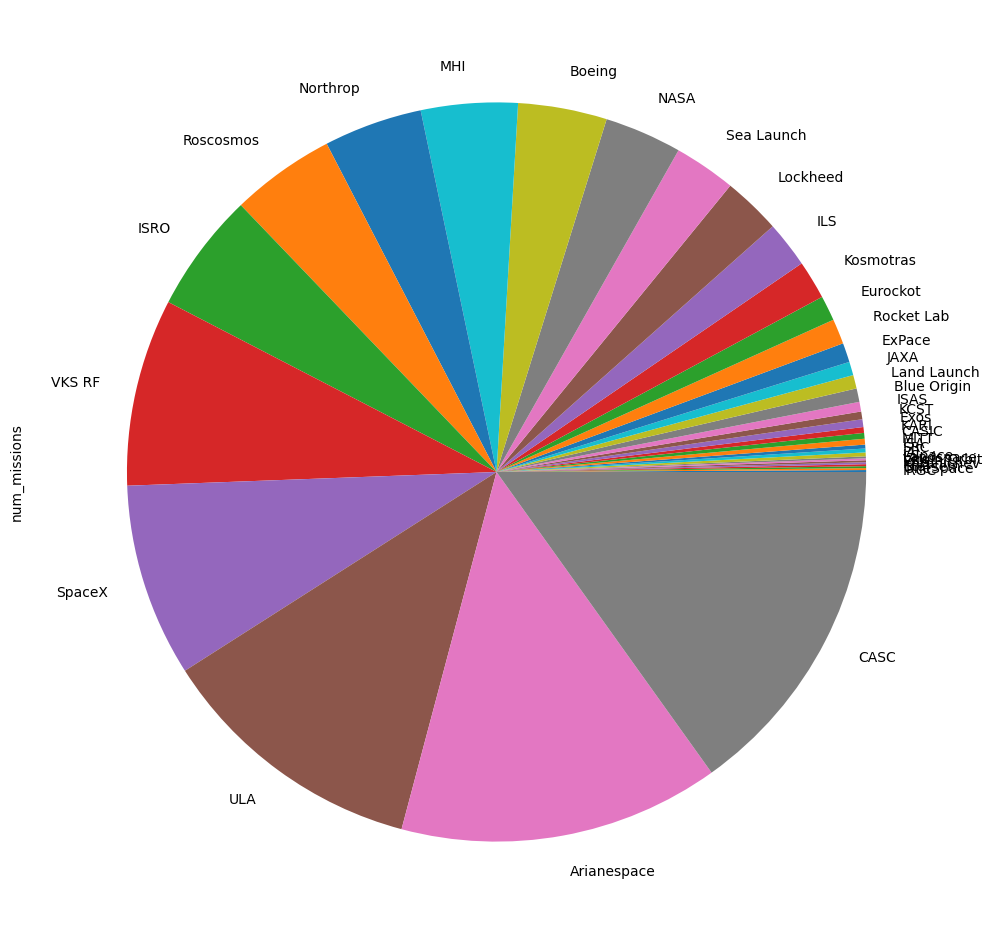

In [47]:
df_validation_pd.plot.pie(figsize=(20,12), y='num_missions', labels=df_validation_pd['company_name'], legend=False)

In [48]:
print(df_missions.schema)

StructType([StructField('id', IntegerType(), nullable=True), StructField('company_name', StringType(), nullable=True), StructField('location', StringType(), nullable=True), StructField('detail', StringType(), nullable=True), StructField('status_rocket', StringType(), nullable=True), StructField('cost', DoubleType(), nullable=True), StructField('status_mission', StringType(), nullable=True), StructField('date', TimestampNTZType(), nullable=True)])


In [49]:
df_validation_pd = session.table("gms3euwest1.mission.missions_summary")
df_missions.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"id"  |"company_name"  |"location"                                         |"detail"                          |"status_rocket"  |"cost"  |"status_mission"  |"date"               |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1213  |Lockheed        |SLC-36A, Cape Canaveral AFS, Florida, USA          |Atlas IIA | DSCS IIIB-8           |StatusRetired    |NULL    |Success           |2000-01-21 01:03:00  |
|1212  |Arianespace     |ELA-2, Guiana Space Centre, French Guiana, France  |Ariane 42L | Galaxy 10R           |StatusRetired    |NULL    |Success           |2000-01-25 01:04:00  |
|1211  |CASC            |LC-2, Xichang Satellite Launch Center, China       |Long March 3A | Ch

In [50]:
nationDF = session.table("tpch.tiny.nation") \
                  .drop("regionkey", "comment") \
                  .rename("name", "nation_name") \
                  .rename("nationkey", "n_nationkey")
nationDF.show()

---------------------------------
|"n_nationkey"  |"nation_name"  |
---------------------------------
|0              |ALGERIA        |
|1              |ARGENTINA      |
|2              |BRAZIL         |
|3              |CANADA         |
|4              |EGYPT          |
|5              |ETHIOPIA       |
|6              |FRANCE         |
|7              |GERMANY        |
|8              |INDIA          |
|9              |INDONESIA      |
---------------------------------



In [51]:
supplierDF = session.table("tpch.tiny.supplier") \
                  .drop("address", "comment") \
#                   .rename("name", "nation_name") \
#                  .rename("nationkey", "n_nationkey")
supplierDF.show()

------------------------------------------------------------------------------
|"suppkey"  |"name"              |"nationkey"  |"phone"          |"acctbal"  |
------------------------------------------------------------------------------
|1          |Supplier#000000001  |17           |27-918-335-1736  |5755.94    |
|2          |Supplier#000000002  |5            |15-679-861-2259  |4032.68    |
|3          |Supplier#000000003  |1            |11-383-516-1199  |4192.4     |
|4          |Supplier#000000004  |15           |25-843-787-7479  |4641.08    |
|5          |Supplier#000000005  |11           |21-151-690-3663  |-283.84    |
|6          |Supplier#000000006  |14           |24-696-997-4969  |1365.79    |
|7          |Supplier#000000007  |23           |33-990-965-2201  |6820.35    |
|8          |Supplier#000000008  |17           |27-498-742-3860  |7627.85    |
|9          |Supplier#000000009  |10           |20-403-398-8662  |5302.37    |
|10         |Supplier#000000010  |24           |34-8

In [52]:
joinedDF = supplierDF.join(nationDF, supplierDF.nationkey == nationDF.n_nationkey)
joinedDF.show()

---------------------------------------------------------------------------------------------------------------
|"suppkey"  |"name"              |"nationkey"  |"phone"          |"acctbal"  |"n_nationkey"  |"nation_name"   |
---------------------------------------------------------------------------------------------------------------
|1          |Supplier#000000001  |17           |27-918-335-1736  |5755.94    |17             |PERU            |
|2          |Supplier#000000002  |5            |15-679-861-2259  |4032.68    |5              |ETHIOPIA        |
|3          |Supplier#000000003  |1            |11-383-516-1199  |4192.4     |1              |ARGENTINA       |
|4          |Supplier#000000004  |15           |25-843-787-7479  |4641.08    |15             |MOROCCO         |
|5          |Supplier#000000005  |11           |21-151-690-3663  |-283.84    |11             |IRAQ            |
|6          |Supplier#000000006  |14           |24-696-997-4969  |1365.79    |14             |KENYA     

In [53]:
projectedJoinDF = joinedDF.drop("nationkey").drop("n_nationkey")
projectedJoinDF.show()

---------------------------------------------------------------------------------
|"suppkey"  |"name"              |"phone"          |"acctbal"  |"nation_name"   |
---------------------------------------------------------------------------------
|1          |Supplier#000000001  |27-918-335-1736  |5755.94    |PERU            |
|2          |Supplier#000000002  |15-679-861-2259  |4032.68    |ETHIOPIA        |
|3          |Supplier#000000003  |11-383-516-1199  |4192.4     |ARGENTINA       |
|4          |Supplier#000000004  |25-843-787-7479  |4641.08    |MOROCCO         |
|5          |Supplier#000000005  |21-151-690-3663  |-283.84    |IRAQ            |
|6          |Supplier#000000006  |24-696-997-4969  |1365.79    |KENYA           |
|7          |Supplier#000000007  |33-990-965-2201  |6820.35    |UNITED KINGDOM  |
|8          |Supplier#000000008  |27-498-742-3860  |7627.85    |PERU            |
|9          |Supplier#000000009  |20-403-398-8662  |5302.37    |IRAN            |
|10         |Sup

In [54]:
orderedDF = projectedJoinDF.sort(col("acctbal"), ascending=False)
orderedDF.show()

--------------------------------------------------------------------------------
|"suppkey"  |"name"              |"phone"          |"acctbal"  |"nation_name"  |
--------------------------------------------------------------------------------
|49         |Supplier#000000049  |34-211-567-6800  |9915.24    |UNITED STATES  |
|44         |Supplier#000000044  |17-713-930-5667  |9759.38    |GERMANY        |
|70         |Supplier#000000070  |16-821-608-1166  |9508.37    |FRANCE         |
|21         |Supplier#000000021  |12-253-590-5816  |9365.8     |BRAZIL         |
|62         |Supplier#000000062  |29-603-653-2494  |9202.57    |ROMANIA        |
|25         |Supplier#000000025  |32-431-945-3541  |9198.31    |RUSSIA         |
|14         |Supplier#000000014  |25-656-247-5058  |9189.82    |MOROCCO        |
|24         |Supplier#000000024  |10-620-939-2254  |9170.71    |ALGERIA        |
|13         |Supplier#000000013  |13-727-620-7813  |9107.22    |CANADA         |
|33         |Supplier#000000

In [60]:
nationDF = session.table("tpch.tiny.nation") \
            .drop("regionkey", "comment") \
            .rename("name", "nation_name") \
            .rename("nationkey", "n_nationkey")
 
apiSQL = session.table("tpch.tiny.customer") \
            .select("name", "acctbal", "nationkey") \
            .filter(col("acctbal") > 9900.0) \
            .join(nationDF, col("nationkey") == nationDF.n_nationkey) \
            .drop("nationkey").drop("n_nationkey") \
            .sort(col("acctbal"), ascending=False)
apiSQL.show()

--------------------------------------------------
|"name"              |"acctbal"  |"nation_name"  |
--------------------------------------------------
|Customer#000000213  |9987.71    |UNITED STATES  |
|Customer#000000045  |9983.38    |INDONESIA      |
|Customer#000001106  |9977.62    |VIETNAM        |
|Customer#000000200  |9967.6     |MOZAMBIQUE     |
|Customer#000000140  |9963.15    |EGYPT          |
|Customer#000000381  |9931.71    |ETHIOPIA       |
|Customer#000000043  |9904.28    |ROMANIA        |
--------------------------------------------------



In [58]:
dfSQL = session.sql("SELECT c.name, c.acctbal, n.name "\
                    "  FROM tpch.tiny.customer c "\
                    "  JOIN tpch.tiny.nation n "\
                    "    ON c.nationkey = n.nationkey "\
                    " WHERE c.acctbal > 9900.0 "\
                    " ORDER BY c.acctbal DESC ")
dfSQL.show()

--------------------------------------------------
|"name"              |"acctbal"  |"name"         |
--------------------------------------------------
|Customer#000000213  |9987.71    |UNITED STATES  |
|Customer#000000045  |9983.38    |INDONESIA      |
|Customer#000001106  |9977.62    |VIETNAM        |
|Customer#000000200  |9967.6     |MOZAMBIQUE     |
|Customer#000000140  |9963.15    |EGYPT          |
|Customer#000000381  |9931.71    |ETHIOPIA       |
|Customer#000000043  |9904.28    |ROMANIA        |
--------------------------------------------------

